In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ua_map = cv2.imread('lab_02_pics/ua_map.png')
bing = cv2.imread('lab_02_pics/bing.png')

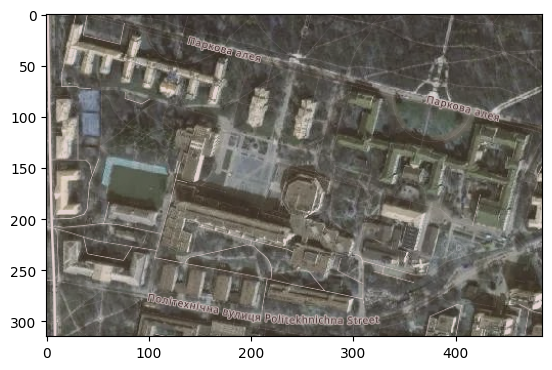

In [3]:
plt.imshow(ua_map)

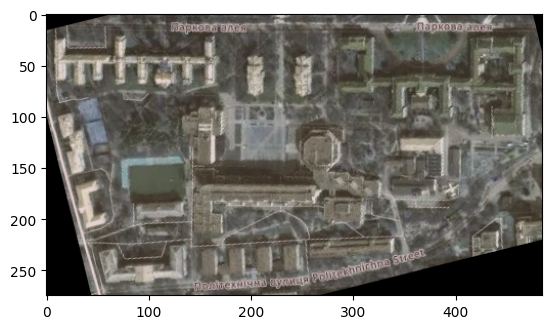

In [4]:
#параметри тут підібрані вручну
height, width = ua_map.shape[:2]
angle = 14
center = (width // 2, height // 2 - 50)
scale = 1.0
rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)
rot_ua_map = cv2.warpAffine(ua_map, rotation_matrix, (width, height))[40:height, 0:width]
plt.imshow(rot_ua_map)

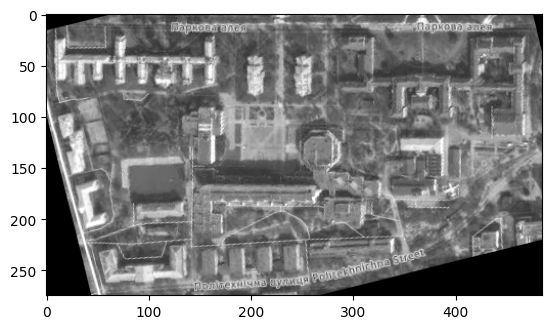

In [5]:
ua_map_gray = cv2.cvtColor(rot_ua_map, cv2.COLOR_BGR2GRAY)
plt.imshow(ua_map_gray, cmap='gray')
ua_map_hsv = cv2.cvtColor(rot_ua_map, cv2.COLOR_BGR2HSV)
#plt.imshow(ua_map_hsv, cmap='hsv')
ua_map_YCRCB = cv2.cvtColor(rot_ua_map, cv2.COLOR_BGR2YCR_CB)
#plt.imshow(ua_map_YCRCB)
ua_map_lab = cv2.cvtColor(rot_ua_map, cv2.COLOR_BGR2LAB)

(np.float64(-0.5), np.float64(484.5), np.float64(274.5), np.float64(-0.5))

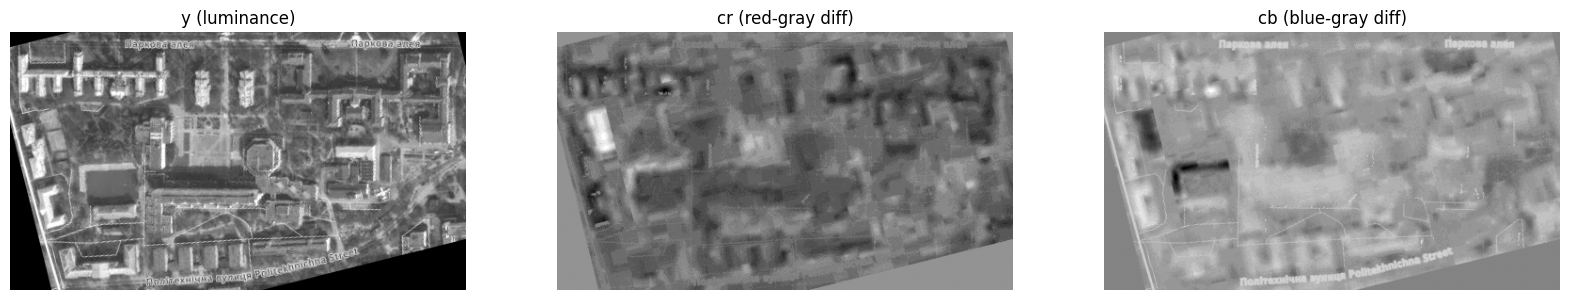

In [6]:
y, cr, cb = cv2.split(ua_map_YCRCB)
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].imshow(y, cmap='gray')
axes[0].set_title('y (luminance)')
axes[0].axis('off')

axes[1].imshow(cr, cmap='gray')
axes[1].set_title('cr (red-gray diff)')
axes[1].axis('off')

axes[2].imshow(cb, cmap='gray')
axes[2].set_title('cb (blue-gray diff)')
axes[2].axis('off')

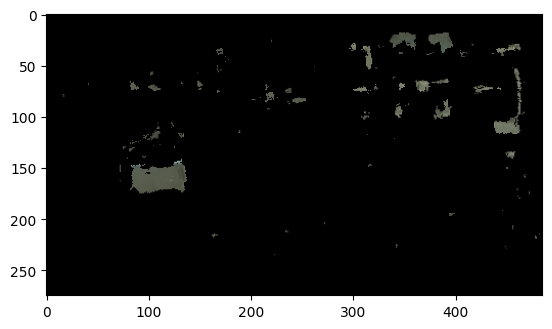

In [7]:
lower_green_hsv = np.array([35, 30, 40])
upper_green_hsv = np.array([85, 255, 255])
mask_green_hsv = cv2.inRange(ua_map_hsv, lower_green_hsv, upper_green_hsv)
masked = cv2.bitwise_and(rot_ua_map, rot_ua_map, mask=mask_green_hsv)
plt.imshow(masked)

(np.float64(-0.5), np.float64(484.5), np.float64(274.5), np.float64(-0.5))

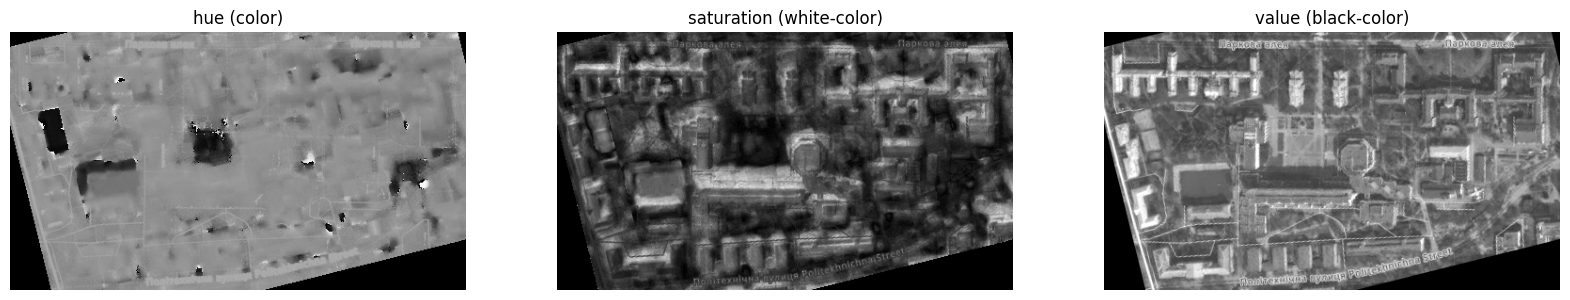

In [8]:
h, s, v = cv2.split(ua_map_hsv)
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].imshow(h, cmap='gray')
axes[0].set_title('hue (color)')
axes[0].axis('off')

axes[1].imshow(s, cmap='gray')
axes[1].set_title('saturation (white-color)')
axes[1].axis('off')

axes[2].imshow(v, cmap='gray')
axes[2].set_title('value (black-color)')
axes[2].axis('off')

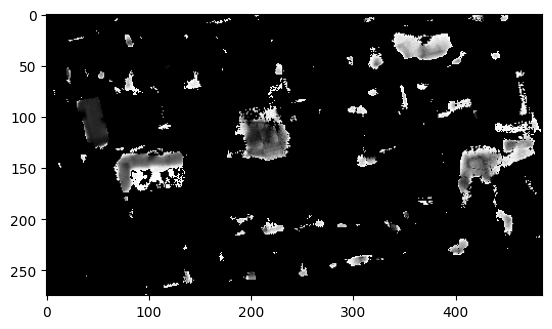

In [9]:
s_mask = cv2.inRange(s, 60, 255)
s_masked = cv2.bitwise_and(s, s, mask=s_mask)

h_mask = cv2.inRange(h, 0, 80)
h_masked = cv2.bitwise_and(h, h, mask=h_mask)
plt.imshow(h_masked, cmap='gray')

0 137
0.0 1.0


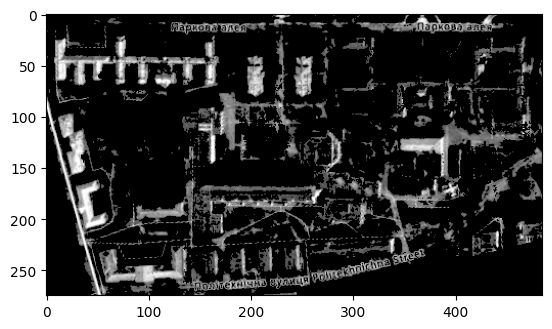

In [10]:
result = cv2.subtract(y, cv2.multiply(cr, 0.6)) # we amplify with red-gray diff that detects some roofs
result = cv2.subtract(result, cv2.multiply(h_masked, 3)) # we subtract hue which detected blue tones
#result = cv2.subtract(result, cv2.multiply(s_masked, 2)) #

result_mask = cv2.inRange(result, 40, 255)
result_masked = cv2.bitwise_and(result, result, mask=result_mask)
#result_masked = result.copy()

print(result_masked.min(), result_masked.max())
result_normalized = (result_masked - result_masked.min()) / (result_masked.max() - result_masked.min())
print(result_normalized.min(), result_normalized.max())
plt.imshow(result_normalized, cmap='gray')

(np.float64(-0.5), np.float64(484.5), np.float64(274.5), np.float64(-0.5))

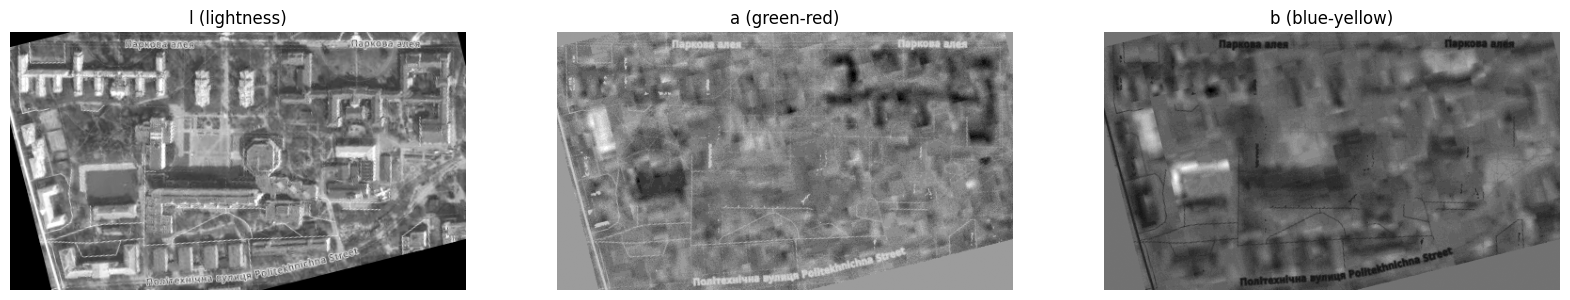

In [11]:
L, A, B = cv2.split(ua_map_lab)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].imshow(L, cmap='gray')
axes[0].set_title('l (lightness)')
axes[0].axis('off')

axes[1].imshow(A, cmap='gray')
axes[1].set_title('a (green-red)')
axes[1].axis('off')

axes[2].imshow(B, cmap='gray')
axes[2].set_title('b (blue-yellow)')
axes[2].axis('off')

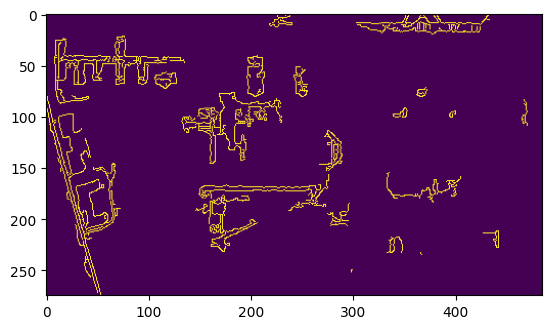

In [12]:
edges = cv2.Canny((result_normalized * 255).astype(np.uint8), 200, 1100)
plt.imshow(edges)

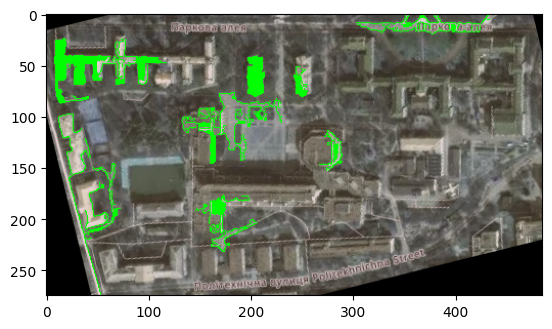

In [13]:
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_contour_area = 65
large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]
rot_ua_map_cp = rot_ua_map.copy()
cv2.drawContours(rot_ua_map_cp, large_contours, -1, (0, 255, 0), -1)
plt.imshow(rot_ua_map_cp)

Препроцес вище був оріентований конкретно на бежеві дахи, але, зважаючи на те, що нам не бажано використовувати фільтри, ерозію або морфологічні операції, підбирати параметри руками дуже довго і важко.

При цьому ми всеодно пропустили бежеву будівлю справа.

Тому, показавши приклад виконання строго лише з корекцією кольору і трешхолдами, в наступній частині я спробую вирішити задачу використовуючи також dilation/erosion і морфологічне закриття контурів.

kmeans basically acts as a multi-level thresholding here

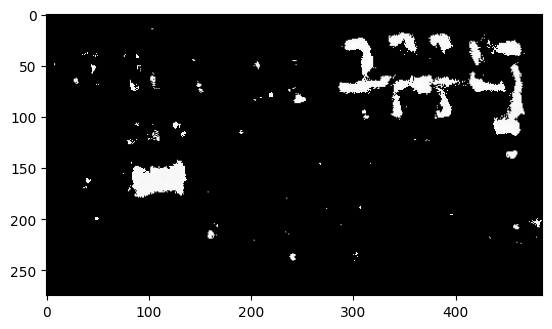

In [14]:
ret,thresh = cv2.threshold(cv2.subtract(255,A), 132,255, cv2.THRESH_TOZERO)
plt.imshow(thresh, cmap='gray')

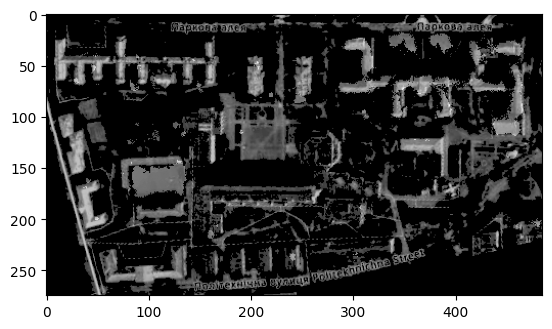

In [45]:
result = cv2.subtract(y, cv2.multiply(cr, 0.6)) # we amplify with red-gray diff that detects some roofs
#result = cv2.subtract(result, cv2.multiply(h_masked, 3)) # we subtract hue which detected blue tones
result = cv2.add(result, cv2.multiply(thresh, 0.5)) #bc the roof on the right is green and it's visible on A from LAB

result_mask = cv2.inRange(result, 40, 255)
result_masked = cv2.bitwise_and(result, result, mask=result_mask)
#result_masked = result.copy()

result_normalized = (result_masked - result_masked.min()) / (result_masked.max() - result_masked.min())
plt.imshow(result_normalized, cmap='gray')

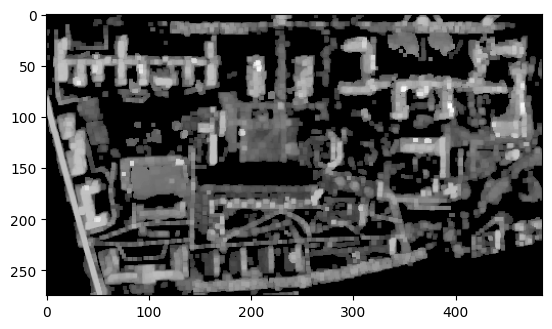

In [46]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
dilated = cv2.dilate((result_normalized*255).astype(np.uint8), kernel, iterations=1)
plt.imshow(dilated, cmap='gray')

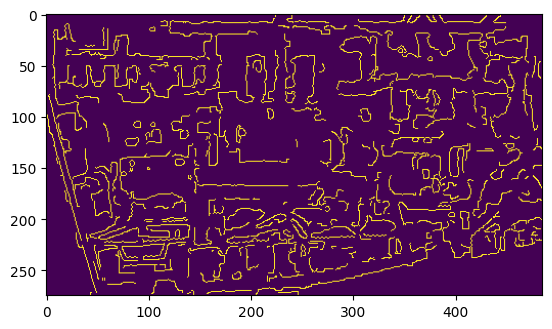

In [49]:
edges = cv2.Canny((dilated).astype(np.uint8), 300, 500)
plt.imshow(edges)

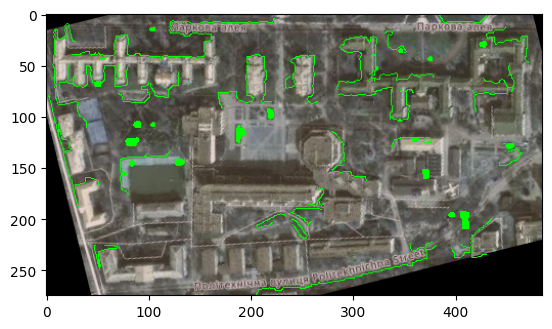

In [50]:
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_contour_area = 10
large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]
rot_ua_map_cp = rot_ua_map.copy()
cv2.drawContours(rot_ua_map_cp, large_contours, -1, (0, 255, 0), -1)
plt.imshow(rot_ua_map_cp)

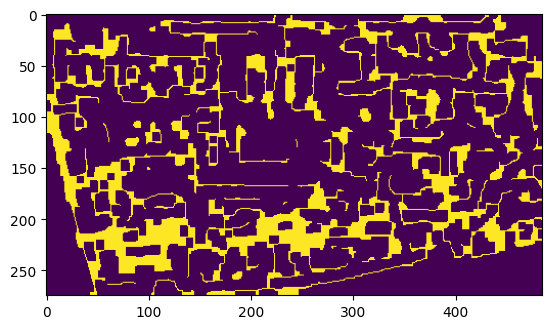

In [51]:
kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel_close)
plt.imshow(closed)

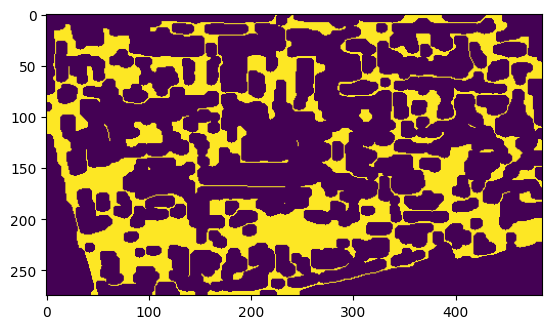

In [52]:
kernel_morph = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
dilated2 = cv2.dilate(closed, kernel_morph, iterations=1)
eroded2 = cv2.erode(dilated2, kernel_morph, iterations=1)
plt.imshow(eroded2)

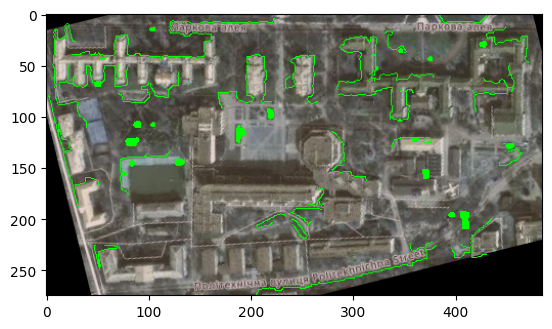

In [53]:
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_contour_area = 10
large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]
rot_ua_map_cp = rot_ua_map.copy()
cv2.drawContours(rot_ua_map_cp, large_contours, -1, (0, 255, 0), -1)
plt.imshow(rot_ua_map_cp)

In [54]:
len(large_contours)

39

інший варіант:

In [23]:
image = rot_ua_map.copy()

In [24]:
def show_image(title, image, is_mask=False):
    plt.figure(figsize=(6, 4))
    if is_mask or len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

In [112]:
LOWER_HSV = np.array([40, 10, 100]) # H, S, V min
UPPER_HSV = np.array([180, 70, 255]) # H, S, V max

MIN_AREA_NOISE_REMOVAL = 200
MIN_FINAL_CONTOUR_AREA = 1000

CLOSE_KERNEL_SIZE = 2
OPENING_KERNEL_SIZE = 4 

CANNY_THRESH_1 = 100
CANNY_THRESH_2 = 800

(np.float64(-0.5), np.float64(484.5), np.float64(274.5), np.float64(-0.5))

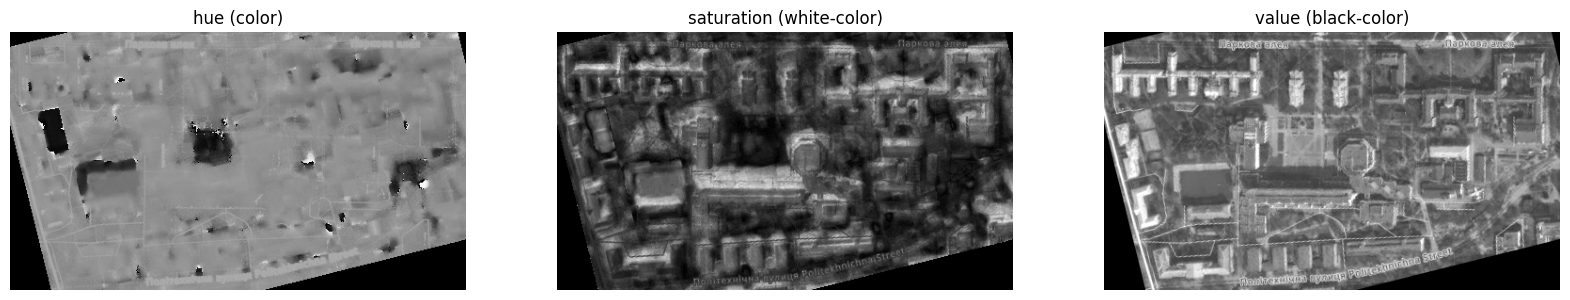

In [113]:
h, s, v = cv2.split(ua_map_hsv)
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].imshow(h, cmap='gray')
axes[0].set_title('hue (color)')
axes[0].axis('off')

axes[1].imshow(s, cmap='gray')
axes[1].set_title('saturation (white-color)')
axes[1].axis('off')

axes[2].imshow(v, cmap='gray')
axes[2].set_title('value (black-color)')
axes[2].axis('off')

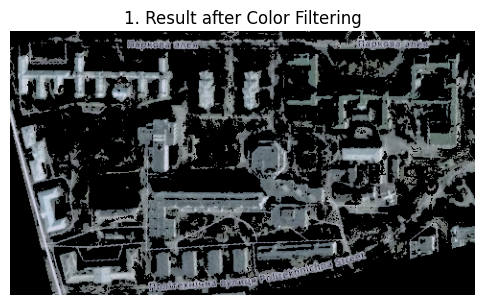

In [115]:
# --- 1. Color Filtering (Gray/White) in HSV ---
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
mask_hsv = cv2.inRange(hsv_image, LOWER_HSV, UPPER_HSV)
result_color_filter = cv2.bitwise_and(image, image, mask=mask_hsv)

show_image('1. Result after Color Filtering', result_color_filter)

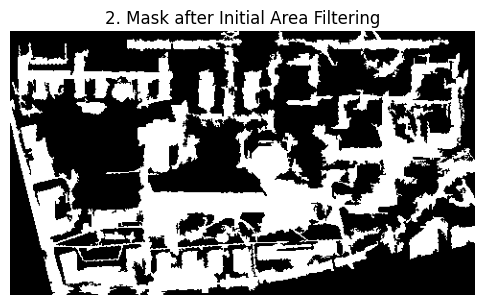

In [116]:
# --- 2. Initial Noise Removal and Area Filtering ---
mask_uint8 = cv2.cvtColor(result_color_filter, cv2.COLOR_BGR2GRAY)
contours, _ = cv2.findContours(mask_uint8, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
large_contours_initial = [cnt for cnt in contours if cv2.contourArea(cnt) > MIN_AREA_NOISE_REMOVAL]
final_mask_area_filtered = np.zeros_like(mask_uint8)
cv2.drawContours(final_mask_area_filtered, large_contours_initial, -1, (255), thickness=cv2.FILLED)
show_image('2. Mask after Initial Area Filtering', final_mask_area_filtered, is_mask=True)

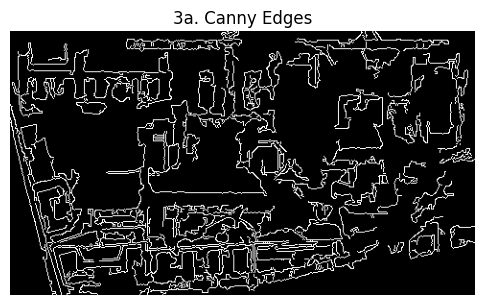

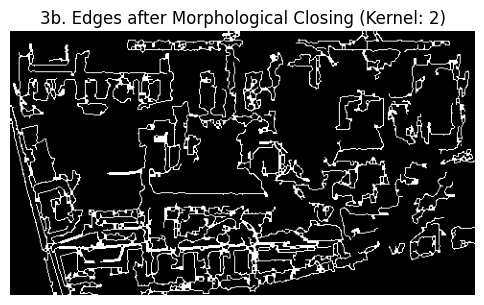

In [117]:
# --- 3. Edge Detection and Morphological Closing ---
final_result_image = cv2.bitwise_and(image, image, mask=final_mask_area_filtered)
gray_result = cv2.cvtColor(final_result_image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray_result, CANNY_THRESH_1, CANNY_THRESH_2)
show_image('3a. Canny Edges', edges, is_mask=True)

close_kernel = np.ones((CLOSE_KERNEL_SIZE, CLOSE_KERNEL_SIZE), np.uint8)
closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, close_kernel)
show_image(f'3b. Edges after Morphological Closing (Kernel: {CLOSE_KERNEL_SIZE})', closed_edges, is_mask=True)

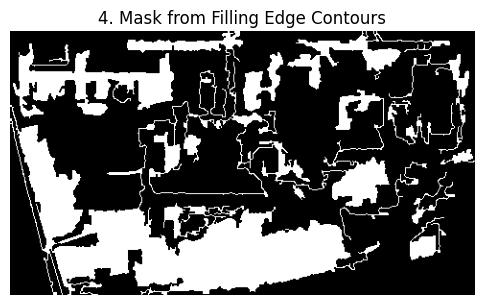

In [118]:
# --- 4. Find and Fill Contours from Closed Edges ---
contours_edge, _ = cv2.findContours(closed_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_contour_area_edge_fill = 80
large_contours_edge = [cnt for cnt in contours_edge if cv2.contourArea(cnt) > min_contour_area_edge_fill]
filled_buildings_mask = np.zeros_like(closed_edges)
cv2.drawContours(filled_buildings_mask, large_contours_edge, -1, (255), thickness=cv2.FILLED)
show_image('4. Mask from Filling Edge Contours', filled_buildings_mask, is_mask=True)

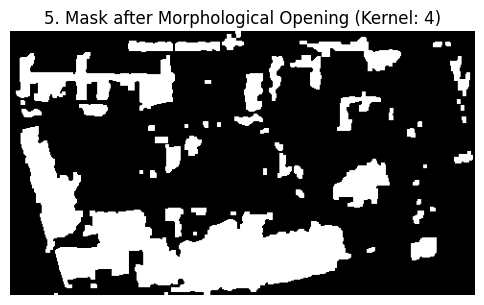

In [119]:
# --- 5. Morphological Opening for Separation and Final Cleanup ---
opening_kernel = np.ones((OPENING_KERNEL_SIZE, OPENING_KERNEL_SIZE), np.uint8)
opened_mask = cv2.morphologyEx(filled_buildings_mask, cv2.MORPH_OPEN, opening_kernel)
show_image(f'5. Mask after Morphological Opening (Kernel: {OPENING_KERNEL_SIZE})', opened_mask, is_mask=True)

In [120]:
# --- 6. Final Contour Detection and Counting ---
final_contours_raw, _ = cv2.findContours(opened_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
final_contours = [cnt for cnt in final_contours_raw if cv2.contourArea(cnt) > MIN_FINAL_CONTOUR_AREA]
num_buildings = len(final_contours)

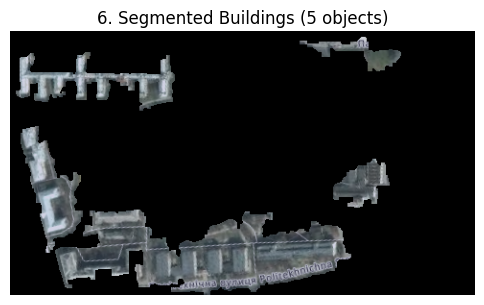

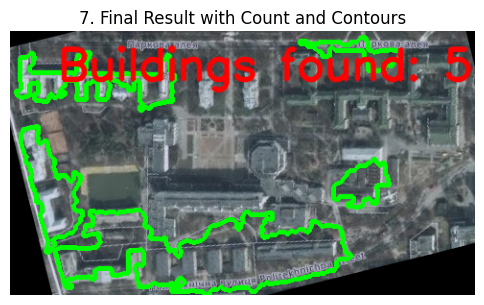

Total buildings detected: 5


In [121]:
# --- 7. Final Visualization and Output ---
final_cleaned_mask = np.zeros_like(opened_mask)
cv2.drawContours(final_cleaned_mask, final_contours, -1, (255), thickness=cv2.FILLED)
final_cleaned_image = cv2.bitwise_and(image, image, mask=final_cleaned_mask)

show_image(f"6. Segmented Buildings ({num_buildings} objects)", final_cleaned_image)

# Visualize the contours and count on the original image
image_with_count = image.copy()
cv2.drawContours(image_with_count, final_contours, -1, (0, 255, 0), 3)
text = f"Buildings found: {num_buildings}"
cv2.putText(image_with_count, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3, cv2.LINE_AA)

show_image("7. Final Result with Count and Contours", image_with_count)
print(f"Total buildings detected: {num_buildings}")

В ідеалі це мають бути всі будівлі, але зараз +- нормально знайдена лише та зліва зверху. Треба дуже довго гратися з параметрами.

Той самий пайплайн на фото з Бінг:

(np.float64(-0.5), np.float64(1489.5), np.float64(815.5), np.float64(-0.5))

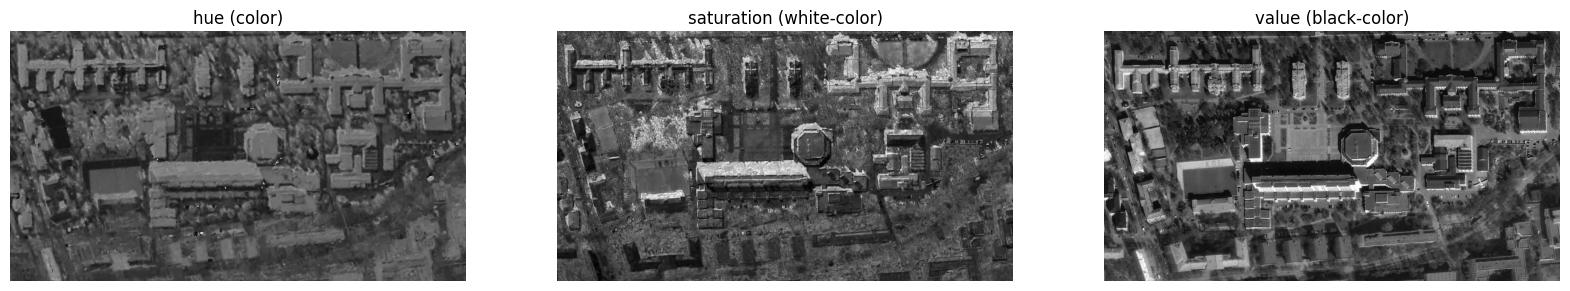

In [137]:
LOWER_HSV = np.array([10, 10, 50]) # H, S, V min
UPPER_HSV = np.array([180, 100, 255]) # H, S, V max

MIN_AREA_NOISE_REMOVAL = 50
MIN_FINAL_CONTOUR_AREA = 1000

CLOSE_KERNEL_SIZE = 2
OPENING_KERNEL_SIZE = 4 

CANNY_THRESH_1 = 100
CANNY_THRESH_2 = 800

# --- 1. Color Filtering (Gray/White) in HSV ---
image = cv2.imread('lab_02_pics/bing.png') 

hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

h, s, v = cv2.split(hsv_image)
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].imshow(h, cmap='gray')
axes[0].set_title('hue (color)')
axes[0].axis('off')

axes[1].imshow(s, cmap='gray')
axes[1].set_title('saturation (white-color)')
axes[1].axis('off')

axes[2].imshow(v, cmap='gray')
axes[2].set_title('value (black-color)')
axes[2].axis('off')

З цим фото легше працювати

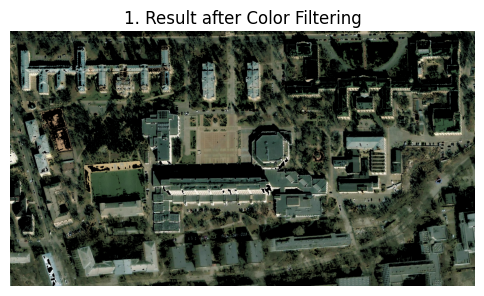

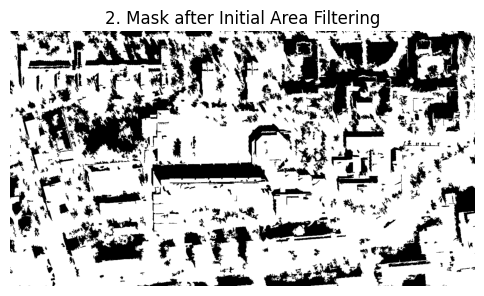

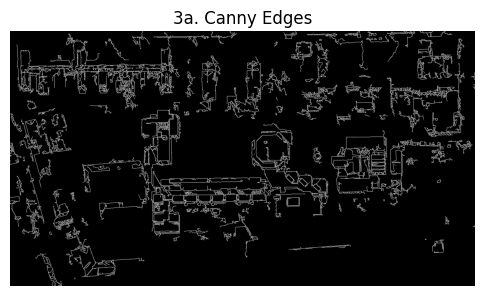

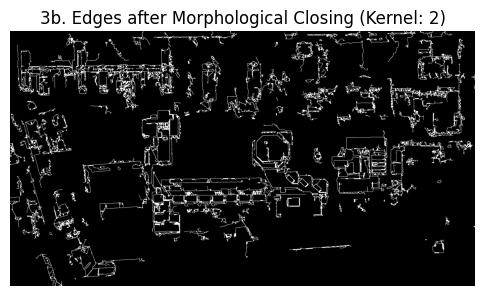

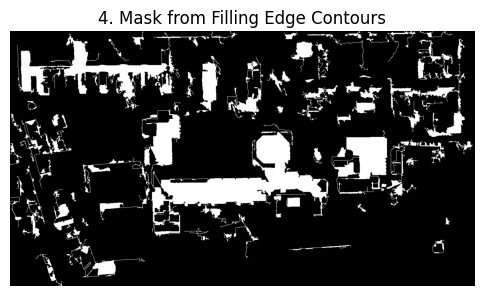

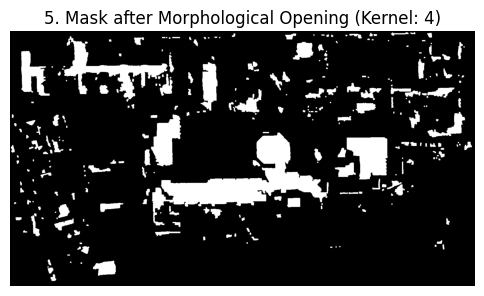

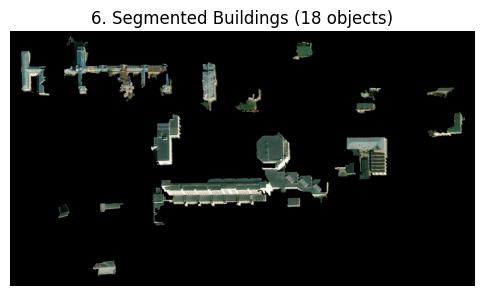

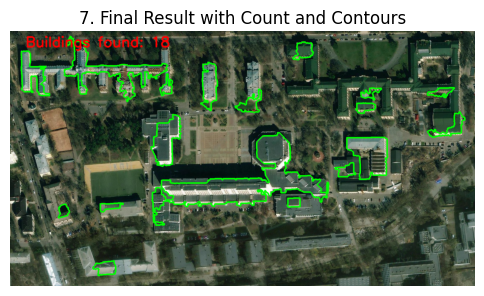

Total buildings detected: 18


In [138]:

mask_hsv = cv2.inRange(hsv_image, LOWER_HSV, UPPER_HSV)
result_color_filter = cv2.bitwise_and(image, image, mask=mask_hsv)

show_image('1. Result after Color Filtering', result_color_filter)

# --- 2. Initial Noise Removal and Area Filtering ---
mask_uint8 = cv2.cvtColor(result_color_filter, cv2.COLOR_BGR2GRAY)
contours, _ = cv2.findContours(mask_uint8, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
large_contours_initial = [cnt for cnt in contours if cv2.contourArea(cnt) > MIN_AREA_NOISE_REMOVAL]
final_mask_area_filtered = np.zeros_like(mask_uint8)
cv2.drawContours(final_mask_area_filtered, large_contours_initial, -1, (255), thickness=cv2.FILLED)
show_image('2. Mask after Initial Area Filtering', final_mask_area_filtered, is_mask=True)

# --- 3. Edge Detection and Morphological Closing ---
final_result_image = cv2.bitwise_and(image, image, mask=final_mask_area_filtered)
gray_result = cv2.cvtColor(final_result_image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray_result, CANNY_THRESH_1, CANNY_THRESH_2)
show_image('3a. Canny Edges', edges, is_mask=True)

close_kernel = np.ones((CLOSE_KERNEL_SIZE, CLOSE_KERNEL_SIZE), np.uint8)
closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, close_kernel)
show_image(f'3b. Edges after Morphological Closing (Kernel: {CLOSE_KERNEL_SIZE})', closed_edges, is_mask=True)

# --- 4. Find and Fill Contours from Closed Edges ---
contours_edge, _ = cv2.findContours(closed_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_contour_area_edge_fill = 80
large_contours_edge = [cnt for cnt in contours_edge if cv2.contourArea(cnt) > min_contour_area_edge_fill]
filled_buildings_mask = np.zeros_like(closed_edges)
cv2.drawContours(filled_buildings_mask, large_contours_edge, -1, (255), thickness=cv2.FILLED)
show_image('4. Mask from Filling Edge Contours', filled_buildings_mask, is_mask=True)

# --- 5. Morphological Opening for Separation and Final Cleanup ---
opening_kernel = np.ones((OPENING_KERNEL_SIZE, OPENING_KERNEL_SIZE), np.uint8)
opened_mask = cv2.morphologyEx(filled_buildings_mask, cv2.MORPH_OPEN, opening_kernel)
show_image(f'5. Mask after Morphological Opening (Kernel: {OPENING_KERNEL_SIZE})', opened_mask, is_mask=True)

# --- 6. Final Contour Detection and Counting ---
final_contours_raw, _ = cv2.findContours(opened_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
final_contours = [cnt for cnt in final_contours_raw if cv2.contourArea(cnt) > MIN_FINAL_CONTOUR_AREA]
num_buildings = len(final_contours)

# --- 7. Final Visualization and Output ---
final_cleaned_mask = np.zeros_like(opened_mask)
cv2.drawContours(final_cleaned_mask, final_contours, -1, (255), thickness=cv2.FILLED)
final_cleaned_image = cv2.bitwise_and(image, image, mask=final_cleaned_mask)

show_image(f"6. Segmented Buildings ({num_buildings} objects)", final_cleaned_image)

# Visualize the contours and count on the original image
image_with_count = image.copy()
cv2.drawContours(image_with_count, final_contours, -1, (0, 255, 0), 3)
text = f"Buildings found: {num_buildings}"
cv2.putText(image_with_count, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3, cv2.LINE_AA)

show_image("7. Final Result with Count and Contours", image_with_count)
print(f"Total buildings detected: {num_buildings}")